<a href="https://colab.research.google.com/github/fboldt/fboldt.github.io/blob/master/CustomClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to create a custom classifier

# Environment setup

## Loading binary dataset

In [1]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
data.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [2]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

## Spliting train and test

In [3]:
from sklearn.model_selection import train_test_split
X,y = data.data,data.target
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(569, 30) (569,)
(381, 30) (188, 30) (381,) (188,)


#Testing a simple classifier

## Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear',multi_class='auto')
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.9521276595744681

## Defining an evaluating class

In [0]:
class PerformanceEvaluator():
  def __init__(self, X, y):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33)
  def score(self, clf):
    clf.fit(self.X_train,self.y_train)
    return clf.score(self.X_test,self.y_test)

## Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(100)

## Evaluating

In [7]:
pe = PerformanceEvaluator(X, y)
print('LogisticRegression     ', pe.score(lr))
print('RandomForestClassifier ', pe.score(rf))

LogisticRegression      0.9521276595744681
RandomForestClassifier  0.925531914893617


## Improving Evaluator

In [8]:
class PerformanceEvaluator():
  def __init__(self, X, y):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33)
  def score(self, clf):
    clf.fit(self.X_train,self.y_train)
    return clf.score(self.X_test,self.y_test)
  def evaluate(self, clfs):
    for name,clf in clfs:
      print('{:>25}: {}'.format(name,self.score(clf)))

clfs = [
    ('LogisticRegression',LogisticRegression(solver='liblinear',multi_class='auto')),
    ('RandomForestClassifier',RandomForestClassifier(100))
]
pe = PerformanceEvaluator(X,y)
pe.evaluate(clfs)

       LogisticRegression: 0.9414893617021277
   RandomForestClassifier: 0.9414893617021277


# Custom Classifier

In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import numpy as np
class ZeroR(BaseEstimator, ClassifierMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    self.answer = Counter(y).most_common(1)[0][0]
  def predict(self, X, y=None):
    return np.ones(X.shape[0])*self.answer

## Evaluate with Custom Classifier

In [10]:
clfs.append(('ZeroR',ZeroR()))
pe.evaluate(clfs)

       LogisticRegression: 0.9414893617021277
   RandomForestClassifier: 0.9521276595744681
                    ZeroR: 0.6436170212765957


## Loading multiclass dataset

In [11]:
from sklearn.datasets import load_wine
data = load_wine()
print(data.keys())
print(data.DESCR)
X,y = data.data,data.target

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])
.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:              

## Testing the new dataset

In [12]:
pe = PerformanceEvaluator(X,y)
pe.evaluate(clfs)

       LogisticRegression: 0.9152542372881356
   RandomForestClassifier: 0.9830508474576272
                    ZeroR: 0.4745762711864407


# Using Keras to implement a Neural Network

In [13]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

labels, ids = np.unique(y_train, return_inverse=True)
y_cat = tf.compat.v1.keras.utils.to_categorical(ids)
model.fit(X_train,y_cat)

predictions = model.predict(X_test)

hits = labels[np.argmax(predictions,axis=1)]==y_test
print(hits.mean())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
119/119 [==============================] - 4s 38ms/sample - loss: 251.8541
0.1864406779661017


## Fitting many times

In [14]:
model.fit(X_train,y_cat, epochs=5)

predictions = model.predict(X_test)

hits = labels[np.argmax(predictions,axis=1)]==y_test
print(hits.mean())

Epoch 1/5
119/119 [==============================] - 0s 132us/sample - loss: 242.7669
Epoch 2/5
119/119 [==============================] - 0s 126us/sample - loss: 236.3913
Epoch 3/5
119/119 [==============================] - 0s 115us/sample - loss: 230.5693
Epoch 4/5
119/119 [==============================] - 0s 117us/sample - loss: 224.9911
Epoch 5/5
119/119 [==============================] - 0s 113us/sample - loss: 219.5603
0.1864406779661017


## Fitting more

In [15]:
model.fit(X_train,y_cat, epochs=500, verbose=False)

predictions = model.predict(X_test)

hits = labels[np.argmax(predictions,axis=1)]==y_test
print(hits.mean())

0.864406779661017


## Wrapping the ANN into a Classifier

In [0]:
import tensorflow as tf

class ANN(BaseEstimator, ClassifierMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y=None):
    self.labels, ids = np.unique(y, return_inverse=True)
    y_cat = tf.compat.v1.keras.utils.to_categorical(ids)
    
    self.model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(y_cat.shape[1], activation='softmax')
    ])    
    self.model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy')
    
    self.model.fit(X,y_cat, epochs=500, verbose=False)
    
  def predict(self, X, y=None):
    predictions = self.model.predict(X)
    return self.labels[np.argmax(predictions,axis=1)]

## Evaluating the ANN

In [17]:
clfs.append(('Artificial Neural Network',ANN()))
pe.evaluate(clfs)

       LogisticRegression: 0.9152542372881356
   RandomForestClassifier: 0.9830508474576272
                    ZeroR: 0.4745762711864407
Artificial Neural Network: 0.847457627118644


## Adding pipeline

In [18]:
clfs.pop()
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
annpl = Pipeline([
    ('Standadization', StandardScaler()),
    ('ann', ANN())
])
clfs.append(('Artificial Neural Network',annpl))
pe.evaluate(clfs)

       LogisticRegression: 0.9152542372881356
   RandomForestClassifier: 0.9830508474576272
                    ZeroR: 0.4745762711864407
Artificial Neural Network: 0.9322033898305084


## ANN with Hidden Layer

In [0]:
import tensorflow as tf

class ANNwHL(BaseEstimator, ClassifierMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y=None):
    self.labels, ids = np.unique(y, return_inverse=True)
    y_cat = tf.compat.v1.keras.utils.to_categorical(ids)
    
    self.model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(X.shape[1]*2, activation='sigmoid'),
        tf.keras.layers.Dense(y_cat.shape[1], activation='softmax')
    ])    
    self.model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy')
    
    self.model.fit(X,y_cat, epochs=500, verbose=False)
    
  def predict(self, X, y=None):
    predictions = self.model.predict(X)
    return self.labels[np.argmax(predictions,axis=1)]



clfs.append(('ANN with Hidden Layer',Pipeline([
    ('Standadization', StandardScaler()),
    ('ann', ANNwHL())
])))


## Evaluating ANN with hidden layer

In [20]:
pe.evaluate(clfs)

       LogisticRegression: 0.9152542372881356
   RandomForestClassifier: 0.9661016949152542
                    ZeroR: 0.4745762711864407
Artificial Neural Network: 0.9322033898305084
    ANN with Hidden Layer: 0.9491525423728814


# Another Dataset

In [21]:
from sklearn.datasets import load_digits
data = load_digits()
print(data.keys())
print(data.DESCR)

X,y = data.data,data.target

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping 

## Plotting some samples

<Figure size 432x288 with 0 Axes>

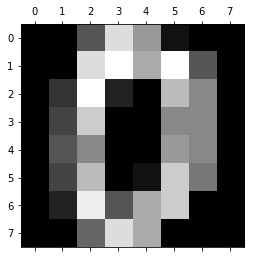

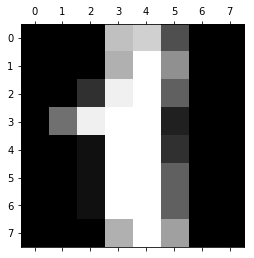

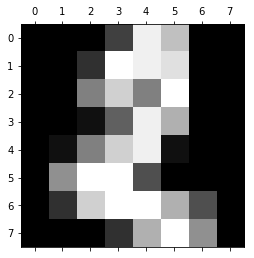

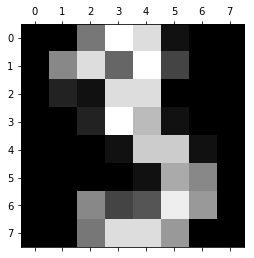

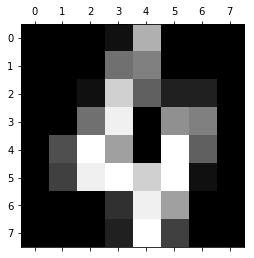

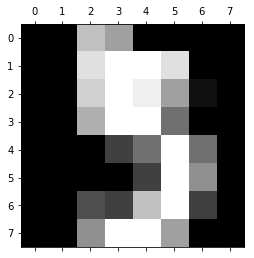

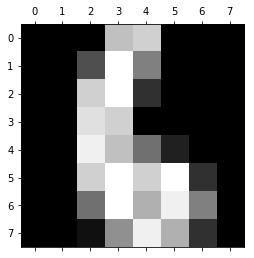

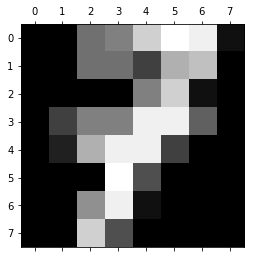

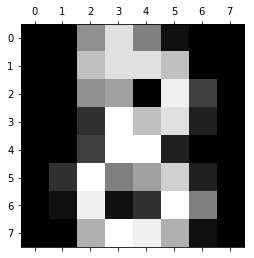

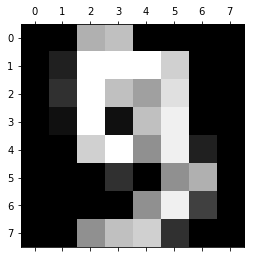

In [22]:
import matplotlib.pyplot as plt
plt.gray()
for i in range(10):
  plt.matshow(data.images[i]) 
  plt.show() 

## Evaluation with Digits dataset

In [23]:
pe = PerformanceEvaluator(X,y)
pe.evaluate(clfs)

       LogisticRegression: 0.9595959595959596
   RandomForestClassifier: 0.9747474747474747
                    ZeroR: 0.09764309764309764
Artificial Neural Network: 0.9663299663299664
    ANN with Hidden Layer: 0.9764309764309764


# Creating a cheat ANN

In [0]:
import tensorflow as tf

class Cheatter(BaseEstimator, ClassifierMixin):
  def __init__(self):    
    self.model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.Dense(10, activation='sigmoid')
    ])    
    self.model.compile(optimizer='rmsprop',
                       loss='categorical_crossentropy')
  
  def fit(self, X, y=None):
    self.labels, ids = np.unique(y, return_inverse=True)
    y_cat = tf.compat.v1.keras.utils.to_categorical(ids)
    self.model.fit(X,y_cat, epochs=1, verbose=False)
    
  def predict(self, X, y=None):
    predictions = self.model.predict(X)
    return self.labels[np.argmax(predictions,axis=1)]


## Cheat evaluator

In [0]:
class CheatPerformanceEvaluator():
  def __init__(self, X, y):
    self.X = X
    self.y = y
  def score(self, clf):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.33)
    clf.fit(self.X_train,self.y_train)
    return clf.score(self.X_test,self.y_test)

## Cheat evaluation

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
  1: 0.7643097643097643
  2: 0.8333333333333334
  3: 0.8703703703703703
  4: 0.8922558922558923
  5: 0.9040404040404041
  6: 0.9276094276094277
  7: 0.9427609427609428
  8: 0.9528619528619529
  9: 0.9511784511784511
 10: 0.9629629629629629
 11: 0.9730639730639731
 12: 0.9814814814814815
 13: 0.9781144781144782
 14: 0.968013468013468
 15: 0.9747474747474747
 16: 0.9814814814814815
 17: 0.9730639730639731
 18: 0.9848484848484849
 19: 0.9831649831649831
 20: 0.9865319865319865
 21: 0.98989898989899
 22: 0.9781144781144782
 23: 0.9865319865319865
 24: 0.9882154882154882
 25: 0.9915824915824916
 26: 0.98989898989899
 27: 0.9932659932659933
 28: 0.9882154882154882
 29: 0.9915824915824916
 30: 0.9915824915824916


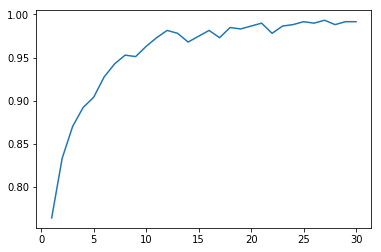

In [26]:
cpe = CheatPerformanceEvaluator(X,y)
cheat = Pipeline([
    ('Standadization', StandardScaler()),
    ('cheatter', Cheatter())
])
scores = []
rounds = 30
for i in range(rounds):
  scores.append(cpe.score(cheat))
  print('{:>3}: {}'.format(i+1,scores[-1]))
plt.plot(list(range(1,rounds+1)),scores)
plt.show()

# Exercise


Improve the class PerformanceEvaluator to:

1.   perform the evaluation of many datasets with many classifiers;
2.   change the performance evaluation by parameter (using a cross validation instead a train/test evalutation);
3.   measure the time spend for each evaluation;
4.   create simple statistics (mean, standard deviation, ...);
5.   return a dictionary with the most important statistics.






